In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as datetime
from IPython.display import Image
import pickle
from datetime import timedelta

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans

import plotly
import plotly.express as px
import plotly.graph_objs as go


import warnings
warnings.filterwarnings('ignore')

# Import cleaned Excel files

In [2]:
df_dem = pd.read_csv(r"D:\Sem 3\PRJ-1\CustomerDemographic_Cleaned.csv")
df_adr = pd.read_csv(r"D:\Sem 3\PRJ-1\CustomerAddress_Cleaned.csv")
df_tr = pd.read_csv(r"D:\Sem 3\PRJ-1\Transaction cleaned.csv")
df_new = pd.read_csv(r"D:\Sem 3\PRJ-1\NewCustomerList_Cleaned.csv")

## Processing on Transaction DataFrame

#### Remove Non-usable variables

In [3]:
df_tr = df_tr.drop(columns=['product_first_sold_date', 'product_id'])

#### Convert date column to date format

In [4]:
df_tr['transaction_date'] = pd.to_datetime(df_tr['transaction_date'], format='%Y-%m-%d')
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19445 entries, 0 to 19444
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transaction_id    19445 non-null  int64         
 1   customer_id       19445 non-null  int64         
 2   transaction_date  19445 non-null  datetime64[ns]
 3   online_order      19445 non-null  float64       
 4   order_status      19445 non-null  object        
 5   brand             19445 non-null  object        
 6   product_line      19445 non-null  object        
 7   product_class     19445 non-null  object        
 8   product_size      19445 non-null  object        
 9   list_price        19445 non-null  float64       
 10  standard_cost     19445 non-null  float64       
 11  Profit            19445 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(5)
memory usage: 1.8+ MB


#### Determine a reference date based on the most recent transaction date

In [5]:
ref_date = df_tr['transaction_date'].max() + timedelta(days=1)
ref_date

Timestamp('2017-12-31 00:00:00')

In [6]:
df_tr['transaction_to_reference_date'] = ref_date - df_tr['transaction_date']
df_tr.head(3)

transaction_id  customer_id transaction_date  online_order order_status  \
0               1         2950       2017-02-25           0.0     Approved   
1               2         3120       2017-05-21           1.0     Approved   
2               3          402       2017-10-16           0.0     Approved   

           brand product_line product_class product_size  list_price  \
0          Solex     Standard        medium       medium       71.49   
1  Trek Bicycles     Standard        medium        large     2091.47   
2     OHM Cycles     Standard           low       medium     1793.43   

   standard_cost   Profit transaction_to_reference_date  
0          53.62    17.87                      309 days  
1         388.92  1702.55                      224 days  
2         248.82  1544.61                       76 days

#### One-Hot Encoding Categorical Columns

In [7]:
df_tr = pd.get_dummies(data=df_tr, columns=['online_order', 'product_line', 'product_class', 'product_size'])
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19445 entries, 0 to 19444
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype          
---  ------                         --------------  -----          
 0   transaction_id                 19445 non-null  int64          
 1   customer_id                    19445 non-null  int64          
 2   transaction_date               19445 non-null  datetime64[ns] 
 3   order_status                   19445 non-null  object         
 4   brand                          19445 non-null  object         
 5   list_price                     19445 non-null  float64        
 6   standard_cost                  19445 non-null  float64        
 7   Profit                         19445 non-null  float64        
 8   transaction_to_reference_date  19445 non-null  timedelta64[ns]
 9   online_order_0.0               19445 non-null  bool           
 10  online_order_1.0               19445 non-null  bool           
 11  pr

#### Drop unused columns

In [8]:
df_tr = df_tr.drop(columns=['online_order_0.0', 'order_status', 'brand', 'transaction_date', 'list_price', 'standard_cost'])
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19445 entries, 0 to 19444
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype          
---  ------                         --------------  -----          
 0   transaction_id                 19445 non-null  int64          
 1   customer_id                    19445 non-null  int64          
 2   Profit                         19445 non-null  float64        
 3   transaction_to_reference_date  19445 non-null  timedelta64[ns]
 4   online_order_1.0               19445 non-null  bool           
 5   product_line_Mountain          19445 non-null  bool           
 6   product_line_Road              19445 non-null  bool           
 7   product_line_Standard          19445 non-null  bool           
 8   product_line_Touring           19445 non-null  bool           
 9   product_class_high             19445 non-null  bool           
 10  product_class_low              19445 non-null  bool           
 11  pr

#### Convert the time delta data type to integer

In [9]:
df_tr['transaction_to_reference_date'] = df_tr['transaction_to_reference_date'].dt.days
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19445 entries, 0 to 19444
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   transaction_id                 19445 non-null  int64  
 1   customer_id                    19445 non-null  int64  
 2   Profit                         19445 non-null  float64
 3   transaction_to_reference_date  19445 non-null  int64  
 4   online_order_1.0               19445 non-null  bool   
 5   product_line_Mountain          19445 non-null  bool   
 6   product_line_Road              19445 non-null  bool   
 7   product_line_Standard          19445 non-null  bool   
 8   product_line_Touring           19445 non-null  bool   
 9   product_class_high             19445 non-null  bool   
 10  product_class_low              19445 non-null  bool   
 11  product_class_medium           19445 non-null  bool   
 12  product_size_large             19445 non-null 

### Customer-level aggregated metrics

In [10]:
df_tr = df_tr.groupby('customer_id').aggregate({'transaction_id':'count',
                                                'transaction_to_reference_date':['min', 'max'],
                                                'Profit':'sum',
                                                'online_order_1.0':'sum',
                                                'product_line_Mountain': 'sum',
                                                'product_line_Road': 'sum',
                                                'product_line_Standard': 'sum',
                                                'product_line_Touring': 'sum',
                                                'product_class_high': 'sum',
                                                'product_class_low': 'sum',
                                                'product_class_medium': 'sum',
                                                'product_size_large': 'sum',
                                                'product_size_medium': 'sum',
                                                'product_size_small': 'sum'
                                                })
df_tr

transaction_id transaction_to_reference_date            Profit  \
                     count                           min  max          sum   
customer_id                                                                  
1                       11                             8  360  3018.090000   
2                        3                           129  241  2226.260000   
3                        7                           103  311  3290.210000   
4                        2                           196  272   220.570000   
5                        6                            17  303  2394.940000   
...                    ...                           ...  ...          ...   
3497                     3                            53  121  1648.320000   
3498                     6                           128  331  3147.330000   
3499                     7                            52  353  4955.250000   
3500                     6                           145  356  1785.860000   
5034                     3                            85  362   269.484972   

            online_order_1.0 product_line_Mountain product_line_Road  \
                         sum                   sum               sum   
customer_id                                                            
1                          6                     1                 3   
2                          1                     0                 0   
3                          1                     1                 3   
4                          1                     0                 0   
5                          2                     1                 3   
...                      ...                   ...               ...   
3497                       2                     0                 0   
3498                       5                     0                 0   
3499                       4                     0                 1   
3500                       2                     0                 1   
5034                       0                     0                 2   

            product_line_Standard product_line_Touring product_class_high  \
                              sum                  sum                sum   
customer_id                                                                 
1                               7                    0                  1   
2                               3                    0                  0   
3                               3                    0                  1   
4                               2                    0                  0   
5                               2                    0                  1   
...                           ...                  ...                ...   
3497                            3                    0                  0   
3498                            5                    1                  1   
3499                            5                    1                  0   
3500                            5                    0                  1   
5034                            1                    0                  0   

            product_class_low product_class_medium product_size_large  \
                          sum                  sum                sum   
customer_id                                                             
1                           2                    8                  0   
2                           0                    3                  0   
3                           2                    4                  3   
4                           0                    2                  1   
5                           2                    3                  2   
...                       ...                  ...                ...   
3497                        0                    3                  1   
3498                        0                    5                  1   
3499                        

#### Simplify DataFrame columns after groupby

In [11]:
df_tr.columns = df_tr.columns.get_level_values(0)
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3492 entries, 1 to 5034
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   transaction_id                 3492 non-null   int64  
 1   transaction_to_reference_date  3492 non-null   int64  
 2   transaction_to_reference_date  3492 non-null   int64  
 3   Profit                         3492 non-null   float64
 4   online_order_1.0               3492 non-null   int64  
 5   product_line_Mountain          3492 non-null   int64  
 6   product_line_Road              3492 non-null   int64  
 7   product_line_Standard          3492 non-null   int64  
 8   product_line_Touring           3492 non-null   int64  
 9   product_class_high             3492 non-null   int64  
 10  product_class_low              3492 non-null   int64  
 11  product_class_medium           3492 non-null   int64  
 12  product_size_large             3492 non-null   int64 

#### Rename DataFrame Columns

In [12]:
df_tr = df_tr.rename(columns = {'transaction_id':'transaction_count',
                                df_tr.columns[1]:'days_since_latest_purchase',
                                df_tr.columns[2]:'days_since_first_purchase',
                                'online_order_1.0':'online_order_count',
                                'Profit':'profit_sum',
                                'product_line_Mountain': 'product_line_mountain_count',
                                'product_line_Road': 'product_line_road_count',
                                'product_line_Standard': 'product_line_standard_count',
                                'product_line_Touring': 'product_line_touring_count',
                                'product_class_high': 'product_class_high_count',
                                'product_class_low': 'product_class_low_count',
                                'product_class_medium': 'product_class_medium_count',
                                'product_size_large': 'product_size_large_count',
                                'product_size_medium': 'product_size_medium_count',
                                'product_size_small': 'product_size_small_count'})

df_tr.columns.values[2] = 'days_since_last_purchase'
df_tr.columns

Index(['transaction_count', 'days_since_first_purchase',
       'days_since_last_purchase', 'profit_sum', 'online_order_count',
       'product_line_mountain_count', 'product_line_road_count',
       'product_line_standard_count', 'product_line_touring_count',
       'product_class_high_count', 'product_class_low_count',
       'product_class_medium_count', 'product_size_large_count',
       'product_size_medium_count', 'product_size_small_count'],
      dtype='object')

In [13]:
df_tr = df_tr.reset_index()
df_tr.head(3)

customer_id  transaction_count  days_since_first_purchase  \
0            1                 11                          8   
1            2                  3                        129   
2            3                  7                        103   

   days_since_last_purchase  profit_sum  online_order_count  \
0                       360     3018.09                   6   
1                       241     2226.26                   1   
2                       311     3290.21                   1   

   product_line_mountain_count  product_line_road_count  \
0                            1                        3   
1                            0                        0   
2                            1                        3   

   product_line_standard_count  product_line_touring_count  \
0                            7                           0   
1                            3                           0   
2                            3                           0   

   product_class_high_count  product_class_low_count  \
0                         1                        2   
1                         0                        0   
2                         1                        2   

   product_class_medium_count  product_size_large_count  \
0                           8                         0   
1                           3                         0   
2                           4                         3   

   product_size_medium_count  product_size_small_count  
0                          9                         2  
1                          3                         0  
2                          2                         2

In [14]:
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3492 entries, 0 to 3491
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   customer_id                  3492 non-null   int64  
 1   transaction_count            3492 non-null   int64  
 2   days_since_first_purchase    3492 non-null   int64  
 3   days_since_last_purchase     3492 non-null   int64  
 4   profit_sum                   3492 non-null   float64
 5   online_order_count           3492 non-null   int64  
 6   product_line_mountain_count  3492 non-null   int64  
 7   product_line_road_count      3492 non-null   int64  
 8   product_line_standard_count  3492 non-null   int64  
 9   product_line_touring_count   3492 non-null   int64  
 10  product_class_high_count     3492 non-null   int64  
 11  product_class_low_count      3492 non-null   int64  
 12  product_class_medium_count   3492 non-null   int64  
 13  product_size_large

## Processing on Customer demographic DataFrame

In [15]:
df_dem.head(3)

customer_id             name  gender  past_3_years_bike_related_purchases  \
0          720     Darrel Canet    Male                                   67   
1         1092   Katlin Creddon  Female                                   56   
2         3410  Merrili Brittin  Female                                   93   

          DOB           job_title job_industry_category     wealth_segment  \
0  1931-10-23  Recruiting Manager                Retail  Affluent Customer   
1  1935-08-22  VP Quality Control                Retail      Mass Customer   
2  1940-09-22             Missing              Property      Mass Customer   

  deceased_indicator owns_car  tenure  Age  
0                  N       No     6.0   92  
1                  N       No     5.0   88  
2                  N       No    16.0   83

In [16]:
df_dem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3912 entries, 0 to 3911
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customer_id                          3912 non-null   int64  
 1   name                                 3912 non-null   object 
 2   gender                               3912 non-null   object 
 3   past_3_years_bike_related_purchases  3912 non-null   int64  
 4   DOB                                  3912 non-null   object 
 5   job_title                            3912 non-null   object 
 6   job_industry_category                3912 non-null   object 
 7   wealth_segment                       3912 non-null   object 
 8   deceased_indicator                   3912 non-null   object 
 9   owns_car                             3912 non-null   object 
 10  tenure                               3912 non-null   float64
 11  Age                           

Filter out deceased customers.

In [17]:
df_dem = df_dem[df_dem['deceased_indicator']=='N']
df_dem.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3910 entries, 0 to 3911
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customer_id                          3910 non-null   int64  
 1   name                                 3910 non-null   object 
 2   gender                               3910 non-null   object 
 3   past_3_years_bike_related_purchases  3910 non-null   int64  
 4   DOB                                  3910 non-null   object 
 5   job_title                            3910 non-null   object 
 6   job_industry_category                3910 non-null   object 
 7   wealth_segment                       3910 non-null   object 
 8   deceased_indicator                   3910 non-null   object 
 9   owns_car                             3910 non-null   object 
 10  tenure                               3910 non-null   float64
 11  Age                                

#### Remove unused columns

In [18]:
df_dem = df_dem.drop(columns=['DOB','name','deceased_indicator'])
df_dem.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3910 entries, 0 to 3911
Data columns (total 9 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customer_id                          3910 non-null   int64  
 1   gender                               3910 non-null   object 
 2   past_3_years_bike_related_purchases  3910 non-null   int64  
 3   job_title                            3910 non-null   object 
 4   job_industry_category                3910 non-null   object 
 5   wealth_segment                       3910 non-null   object 
 6   owns_car                             3910 non-null   object 
 7   tenure                               3910 non-null   float64
 8   Age                                  3910 non-null   int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 305.5+ KB


#### Clean the columns

In [19]:
df_dem['job_industry_category'].unique()

array(['Retail', 'Property', 'Manufacturing', 'Health',
       'Financial Services', 'Missing', 'IT', 'Entertainment',
       'Agriculture', 'Telecommunications'], dtype=object)

## Processing on Customer address DataFrame

In [20]:
df_adr.head(3)

customer_id              address  postcode state    country  \
0            1   060 Morning Avenue      2016   NSW  Australia   
1            2  6 Meadow Vale Court      2153   NSW  Australia   
2            4   0 Holy Cross Court      4211   QLD  Australia   

   property_valuation  
0                  10  
1                  10  
2                   9

In [21]:
len(df_adr['postcode'].unique())

873

#### Remove unused column

In [22]:
df_adr = df_adr.drop(columns=['address', 'postcode', 'country'])

#### Getting Information of Different DataFrames

In [23]:
df_adr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id         3999 non-null   int64 
 1   state               3999 non-null   object
 2   property_valuation  3999 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 93.9+ KB


In [24]:
df_dem.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3910 entries, 0 to 3911
Data columns (total 9 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customer_id                          3910 non-null   int64  
 1   gender                               3910 non-null   object 
 2   past_3_years_bike_related_purchases  3910 non-null   int64  
 3   job_title                            3910 non-null   object 
 4   job_industry_category                3910 non-null   object 
 5   wealth_segment                       3910 non-null   object 
 6   owns_car                             3910 non-null   object 
 7   tenure                               3910 non-null   float64
 8   Age                                  3910 non-null   int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 305.5+ KB


In [25]:
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3492 entries, 0 to 3491
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   customer_id                  3492 non-null   int64  
 1   transaction_count            3492 non-null   int64  
 2   days_since_first_purchase    3492 non-null   int64  
 3   days_since_last_purchase     3492 non-null   int64  
 4   profit_sum                   3492 non-null   float64
 5   online_order_count           3492 non-null   int64  
 6   product_line_mountain_count  3492 non-null   int64  
 7   product_line_road_count      3492 non-null   int64  
 8   product_line_standard_count  3492 non-null   int64  
 9   product_line_touring_count   3492 non-null   int64  
 10  product_class_high_count     3492 non-null   int64  
 11  product_class_low_count      3492 non-null   int64  
 12  product_class_medium_count   3492 non-null   int64  
 13  product_size_large

In [26]:
df = pd.merge(df_tr, df_dem, on='customer_id')
df = pd.merge(df, df_adr, on='customer_id')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3409 entries, 0 to 3408
Data columns (total 26 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customer_id                          3409 non-null   int64  
 1   transaction_count                    3409 non-null   int64  
 2   days_since_first_purchase            3409 non-null   int64  
 3   days_since_last_purchase             3409 non-null   int64  
 4   profit_sum                           3409 non-null   float64
 5   online_order_count                   3409 non-null   int64  
 6   product_line_mountain_count          3409 non-null   int64  
 7   product_line_road_count              3409 non-null   int64  
 8   product_line_standard_count          3409 non-null   int64  
 9   product_line_touring_count           3409 non-null   int64  
 10  product_class_high_count             3409 non-null   int64  
 11  product_class_low_count       

In [27]:
df['average_profit_per_transaction'] = df['profit_sum'] / df['transaction_count']
df

customer_id  transaction_count  days_since_first_purchase  \
0               1                 11                          8   
1               2                  3                        129   
2               4                  2                        196   
3               5                  6                         17   
4               6                  5                         65   
...           ...                ...                        ...   
3404         3496                  4                        257   
3405         3497                  3                         53   
3406         3498                  6                        128   
3407         3499                  7                         52   
3408         3500                  6                        145   

      days_since_last_purchase  profit_sum  online_order_count  \
0                          360     3018.09                   6   
1                          241     2226.26                   1   
2                          272      220.57                   1   
3                          303     2394.94                   2   
4                          337     3946.55                   2   
...                        ...         ...                 ...   
3404                       299     2045.84                   3   
3405                       121     1648.32                   2   
3406                       331     3147.33                   5   
3407                       353     4955.25                   4   
3408                       356     1785.86                   2   

      product_line_mountain_count  product_line_road_count  \
0                               1                        3   
1                               0                        0   
2                               0                        0   
3                               1                        3   
4                               0                        0   
...                           ...                      ...   
3404                            1                        1   
3405                            0                        0   
3406                            0                        0   
3407                            0                        1   
3408                            0                        1   

      product_line_standard_count  product_line_touring_count  ...  \
0                               7                           0  ...   
1                               3                           0  ...   
2                               2                           0  ...   
3                               2                           0  ...   
4                               5                           0  ...   
...                           ...                         ...  ...   
3404                            2                           0  ...   
3405                            3                           0  ...   
3406                            5                           1  ...   
3407                            5                           1  ...   
3408                            5                           0  ...   

      past_3_years_bike_related_purchases                    job_title  \
0                                      93          Executive Secretary   
1                                      81       Administrative Officer   
2                                      33                      Missing   
3                                      56                Senior Editor   
4                                      35                      Missing   
...                                   ...                          ...   
3404                                   99                       Editor   
3405                                   73  Administrative Assistant IV   
3406                                   28                      Missing   
3407                                   29                      Missing   
3408    

In [28]:
df['job_title'].unique()

array(['Executive Secretary', 'Administrative Officer', 'Missing',
       'Senior Editor', 'Media Manager I',
       'Business Systems Development Analyst', 'Nuclear Power Engineer',
       'Developer I', 'Account Executive', 'Junior Executive',
       'Media Manager IV', 'Sales Associate', 'Professor',
       'Geological Engineer', 'Project Manager', 'Safety Technician I',
       'Research Assistant I', 'Accounting Assistant III', 'Editor',
       'Research Nurse', 'Senior Quality Engineer',
       'Safety Technician III', 'Staff Accountant III', 'Legal Assistant',
       'Product Engineer', 'Information Systems Manager',
       'VP Quality Control', 'Social Worker', 'Senior Cost Accountant',
       'Assistant Media Planner', 'Payment Adjustment Coordinator',
       'Food Chemist', 'Accountant III', 'Director of Sales',
       'Senior Financial Analyst', 'Registered Nurse',
       'Biostatistician II', 'Computer Systems Analyst II',
       'Software Test Engineer II', 'Paralegal', 'VP

In [29]:
df = df[df['job_title'] != df['job_title'].value_counts().idxmax()]

### Visualize the data

In [30]:
df.columns

Index(['customer_id', 'transaction_count', 'days_since_first_purchase',
       'days_since_last_purchase', 'profit_sum', 'online_order_count',
       'product_line_mountain_count', 'product_line_road_count',
       'product_line_standard_count', 'product_line_touring_count',
       'product_class_high_count', 'product_class_low_count',
       'product_class_medium_count', 'product_size_large_count',
       'product_size_medium_count', 'product_size_small_count', 'gender',
       'past_3_years_bike_related_purchases', 'job_title',
       'job_industry_category', 'wealth_segment', 'owns_car', 'tenure', 'Age',
       'state', 'property_valuation', 'average_profit_per_transaction'],
      dtype='object')

#### Age Column Infographs

In [31]:
df['Age'].max()

92

In [32]:
df = df[df['Age'] < 75]

#### The owns car column needs fixing

In [33]:
df['owns_car'] = df['owns_car'].replace({'Yes':1, 'No':0})
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2990 entries, 0 to 3405
Data columns (total 27 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customer_id                          2990 non-null   int64  
 1   transaction_count                    2990 non-null   int64  
 2   days_since_first_purchase            2990 non-null   int64  
 3   days_since_last_purchase             2990 non-null   int64  
 4   profit_sum                           2990 non-null   float64
 5   online_order_count                   2990 non-null   int64  
 6   product_line_mountain_count          2990 non-null   int64  
 7   product_line_road_count              2990 non-null   int64  
 8   product_line_standard_count          2990 non-null   int64  
 9   product_line_touring_count           2990 non-null   int64  
 10  product_class_high_count             2990 non-null   int64  
 11  product_class_low_count            

#### Visualize the data to identify patterns and anomalies

In [34]:
viz_num = ['average_profit_per_transaction',
           'online_order_count',
           'days_since_first_purchase',
           'days_since_last_purchase',
           'past_3_years_bike_related_purchases',
           'owns_car',
           'tenure',
           'Age',
           'property_valuation']

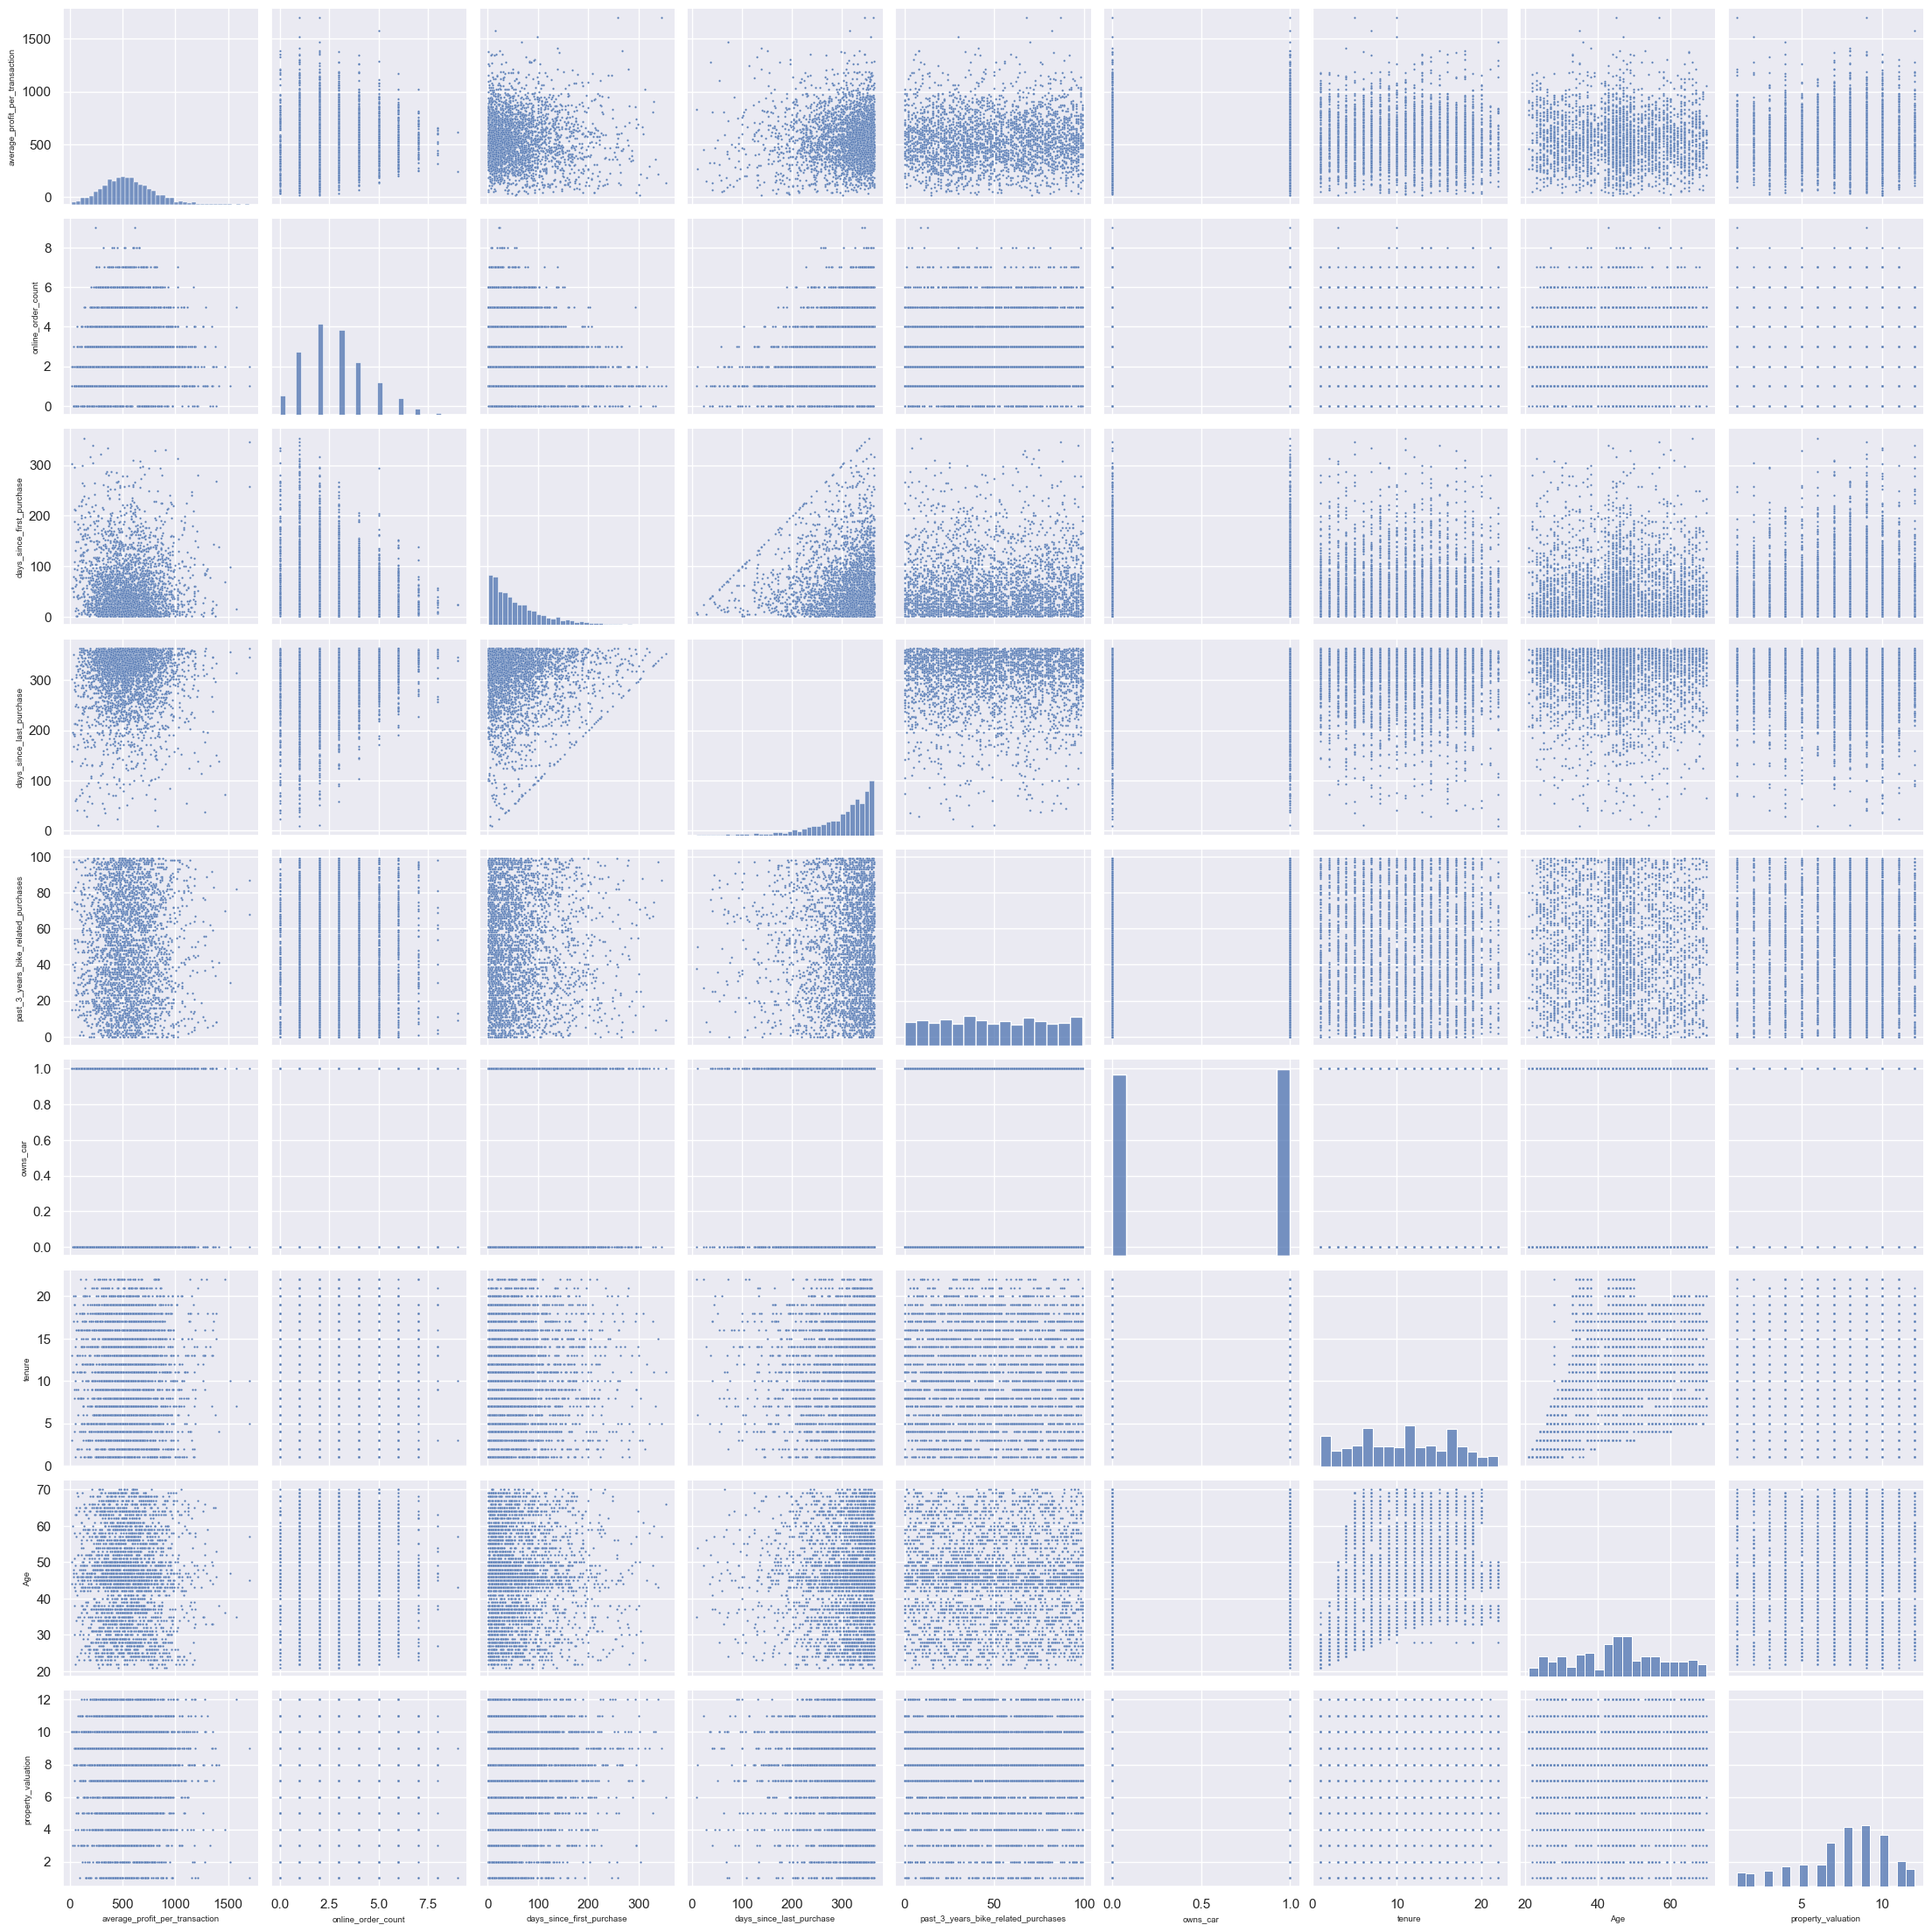

In [35]:
 sns.set(rc={'figure.figsize':(70, 70), 'axes.labelsize':7})
 sns.pairplot(df[viz_num], plot_kws={'s':3})

In [36]:
df.columns

Index(['customer_id', 'transaction_count', 'days_since_first_purchase',
       'days_since_last_purchase', 'profit_sum', 'online_order_count',
       'product_line_mountain_count', 'product_line_road_count',
       'product_line_standard_count', 'product_line_touring_count',
       'product_class_high_count', 'product_class_low_count',
       'product_class_medium_count', 'product_size_large_count',
       'product_size_medium_count', 'product_size_small_count', 'gender',
       'past_3_years_bike_related_purchases', 'job_title',
       'job_industry_category', 'wealth_segment', 'owns_car', 'tenure', 'Age',
       'state', 'property_valuation', 'average_profit_per_transaction'],
      dtype='object')

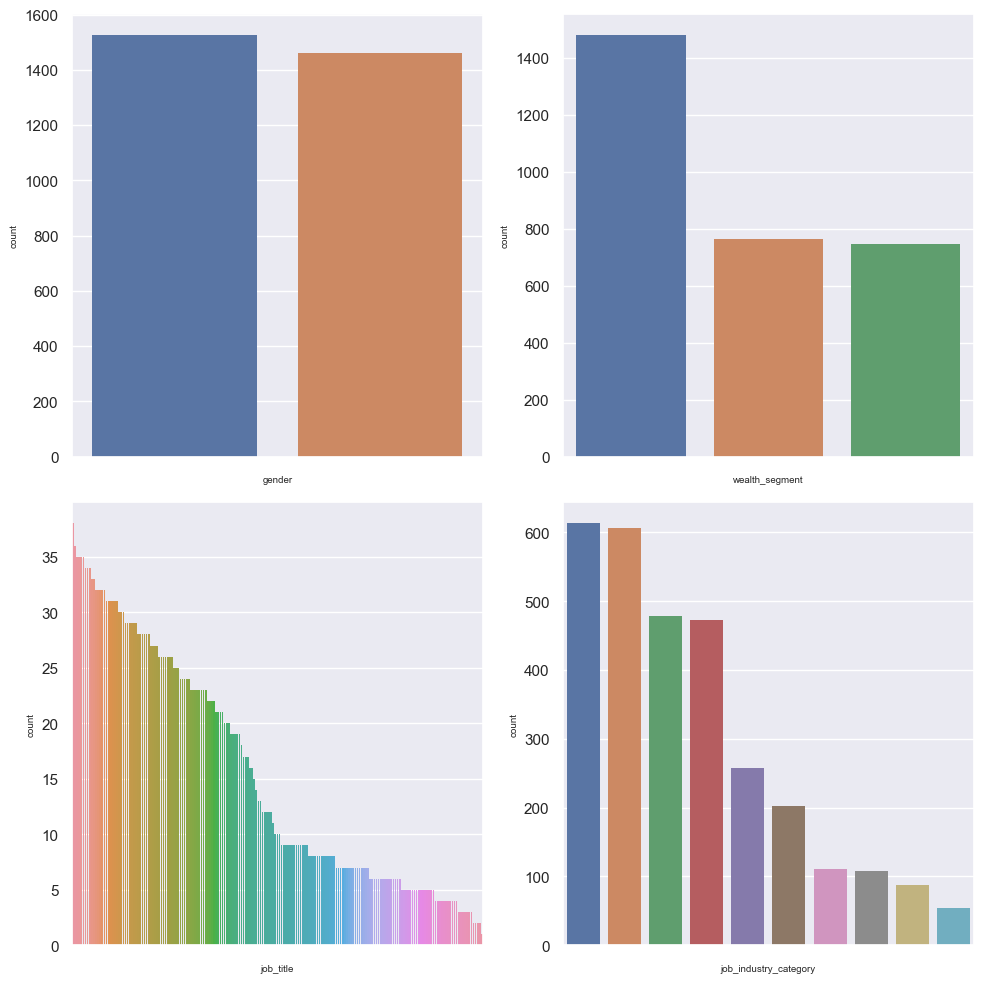

In [37]:
viz_cat = ['gender', 'wealth_segment', 'job_title', 'job_industry_category']

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for idx, category in enumerate(viz_cat):
    ax = axes[idx // 2, idx % 2]  
    sns.countplot(ax=ax, data=df, x=category, lw=0, order=df[category].value_counts().index)
    ax.set(xticklabels=[])

plt.tight_layout()
plt.show()

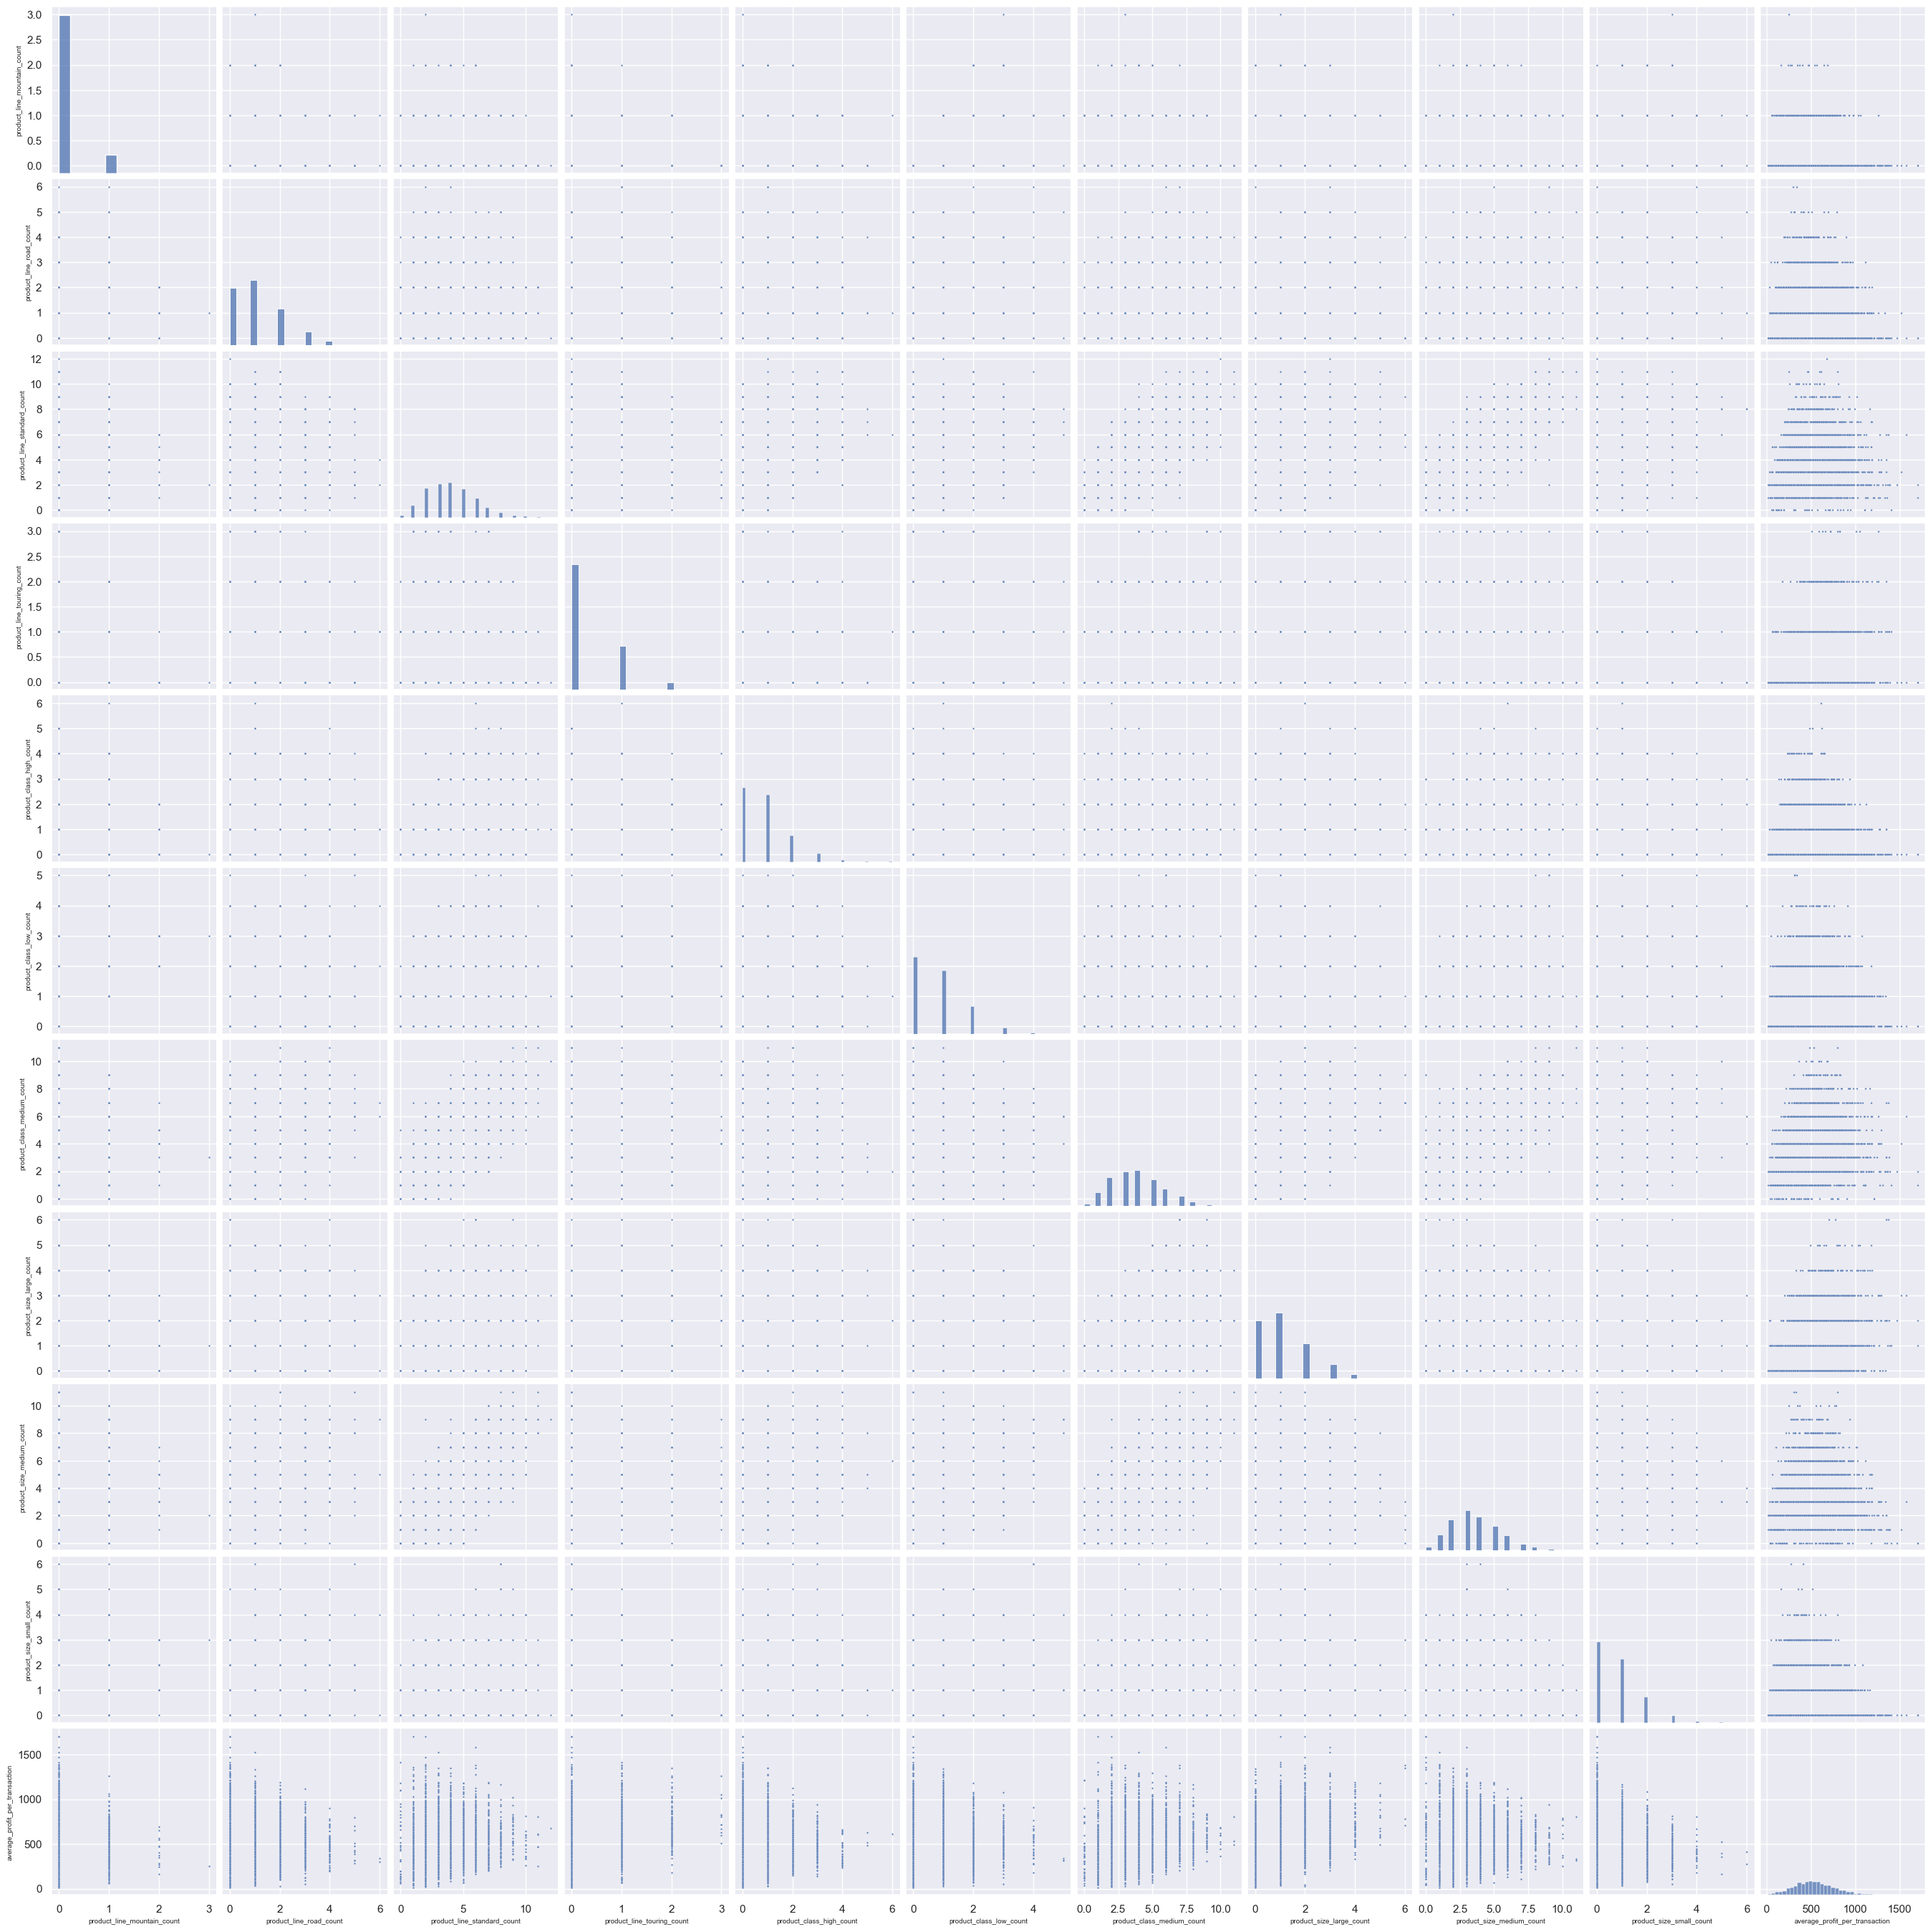

In [38]:
 viz_num2 = ['product_line_mountain_count', 'product_line_road_count', 'product_line_standard_count', 'product_line_touring_count',
             'product_class_high_count', 'product_class_low_count', 'product_class_medium_count', 'product_size_large_count',
             'product_size_medium_count', 'product_size_small_count', 'average_profit_per_transaction']
 sns.set(rc={'figure.figsize':(70, 70), 'axes.labelsize':7})
 sns.pairplot(df[viz_num2], plot_kws={'s':3})

Copy the stable state of the main data frame.

In [39]:
df_copy = df.copy()

Reverting the data frame to stable state. Use this just for tweaking the features.

In [40]:
 df = df_copy

There are still null values in the columns. Fill them.

In [41]:
df = df.fillna({'job_industry_category':'No Info', 'tenure':0})

## Model working

In [42]:
df = df.drop(columns=['customer_id', 'job_title'])

Create dummy variables for several categorical columns.

In [43]:
df = pd.get_dummies(data=df, columns=['gender', 'job_industry_category', 'wealth_segment', 'state'])
df.head()

transaction_count  days_since_first_purchase  days_since_last_purchase  \
0                 11                          8                       360   
1                  3                        129                       241   
3                  6                         17                       303   
6                  9                         23                       361   
7                  6                         79                       330   

   profit_sum  online_order_count  product_line_mountain_count  \
0     3018.09                   6                            1   
1     2226.26                   1                            0   
3     2394.94                   2                            1   
6     5364.39                   5                            0   
7     2353.11                   1                            0   

   product_line_road_count  product_line_standard_count  \
0                        3                            7   
1                        0                            3   
3                        3                            2   
6                        1                            7   
7                        1                            5   

   product_line_touring_count  product_class_high_count  ...  \
0                           0                         1  ...   
1                           0                         0  ...   
3                           0                         1  ...   
6                           1                         3  ...   
7                           0                         1  ...   

   job_industry_category_Missing  job_industry_category_Property  \
0                          False                           False   
1                          False                           False   
3                           True                           False   
6                           True                           False   
7                          False                           False   

   job_industry_category_Retail  job_industry_category_Telecommunications  \
0                         False                                     False   
1                         False                                     False   
3                         False                                     False   
6                         False                                     False   
7                         False                                     False   

   wealth_segment_Affluent Customer  wealth_segment_High Net Worth  \
0                             False                          False   
1                             False                          False   
3                              True                          False   
6                             False                          False   
7                              True                          False   

   wealth_segment_Mass Customer  state_NSW  state_QLD  state_VIC  
0                          True       True      False      False  
1                          True       True      False      False  
3                         False       True      False      False  
6                          True       True      False      False  
7                         False       True      False      False  

[5 rows x 39 columns]

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2990 entries, 0 to 3405
Data columns (total 39 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   transaction_count                         2990 non-null   int64  
 1   days_since_first_purchase                 2990 non-null   int64  
 2   days_since_last_purchase                  2990 non-null   int64  
 3   profit_sum                                2990 non-null   float64
 4   online_order_count                        2990 non-null   int64  
 5   product_line_mountain_count               2990 non-null   int64  
 6   product_line_road_count                   2990 non-null   int64  
 7   product_line_standard_count               2990 non-null   int64  
 8   product_line_touring_count                2990 non-null   int64  
 9   product_class_high_count                  2990 non-null   int64  
 10  product_class_low_count                  

In [45]:
X_unscaled = df.drop(columns = ['average_profit_per_transaction'])
y = df['average_profit_per_transaction']

scaler = StandardScaler()
scaler.fit(X_unscaled)
X = scaler.transform(X_unscaled)

Train the model only if there is no existing model file in the directory.

In [46]:
rf_model_file = 'kpmg_rf_model_file.pkl'

def cv_hyperparameter_rf(X, y):

    if not os.path.isfile(rf_model_file):

        rf = RandomForestRegressor()
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        
        param_dist = {
            'n_estimators': [100, 200, 300],
            'max_depth': [5, 7, 10],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2']
        }

        randomized_search = RandomizedSearchCV(
            rf, param_distributions=param_dist, n_iter=10, cv=cv, scoring='neg_mean_absolute_error', random_state=42, n_jobs=-1
        )
        randomized_search.fit(X, y)

        print('MEAN CROSS-VALIDATION SCORE: ', np.abs(randomized_search.best_score_))
        print('BEST HYPERPARAMETERS: ', randomized_search.best_params_)
        print('Parameter tuning with randomized search finished. Starting the model training with best performing parameters...')
        
        best_params = randomized_search.best_params_
        rf_model = train_rf(X, y, best_params)
      
        return rf_model
        
    else:
        print('There is already a saved model in the directory.')

def train_rf(X, y, best_params):

    rf = RandomForestRegressor(**best_params)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=12)
    rf_model = rf.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)
    mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
    

    print('MEAN ABSOLUTE ERROR OF TRAINED BEST MODEL: ', mae)

    pickle.dump(rf_model, open(rf_model_file, 'wb'))

    return rf_model


In [47]:
cv_hyperparameter_rf(X, y)

MEAN CROSS-VALIDATION SCORE:  93.68744840423214
BEST HYPERPARAMETERS:  {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10}
Parameter tuning with randomized search finished. Starting the model training with best performing parameters...
MEAN ABSOLUTE ERROR OF TRAINED BEST MODEL:  90.49778831948919


RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=300)

Get the mean of the target variable to compare with the MAE of the model.

In [48]:
y.mean()

550.6817762779118

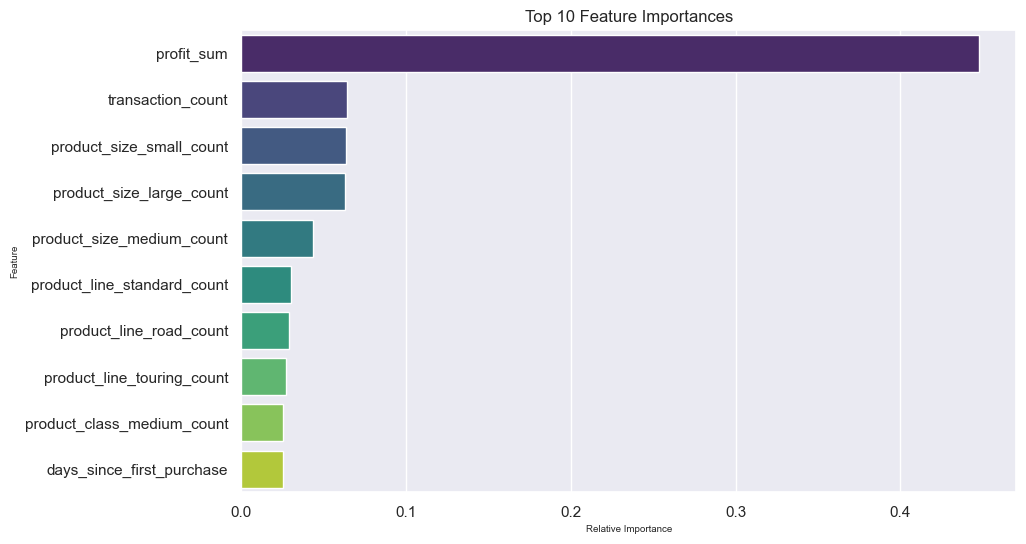

In [49]:
# Load the trained model
rf_model = pickle.load(open(rf_model_file, 'rb'))

# Get feature importances
features = X_unscaled.columns
importances = rf_model.feature_importances_

# Create a DataFrame for easier plotting
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df[:10], palette='viridis')
plt.title('Top 10 Feature Importances')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.show()

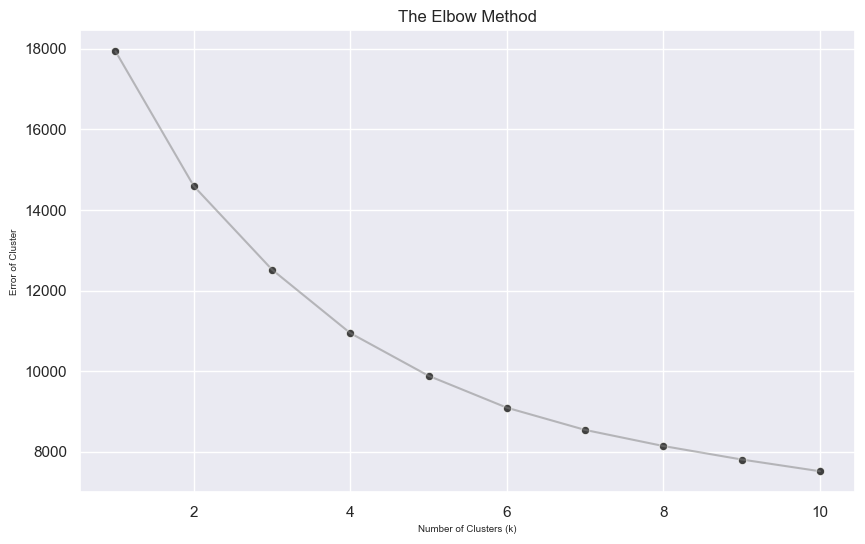

In [50]:
# Select features for clustering
features = ['product_size_large_count', 'product_size_small_count', 'product_line_road_count', 'product_line_touring_count', 'product_line_standard_count', 'days_since_last_purchase']
X_cluster = df[features]

# Standardize the features
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# Initialize a list to store the error for each number of clusters
error = []

# Use the Elbow method to find the optimal number of clusters
for k in range(1, 11):
    model = KMeans(n_clusters=k, random_state=12)
    model.fit(X_cluster_scaled)
    error.append(model.inertia_)

# Plot the Elbow curve with blurred line connecting the data points
plt.figure(figsize=(10, 6))
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Error of Cluster')

# Plot blurred line connecting the data points
sns.lineplot(x=list(range(1, 11)), y=error, marker='o', linestyle='-', color='grey', alpha=0.5)

# Plot data points
sns.scatterplot(x=list(range(1, 11)), y=error, marker='o', color='black')

plt.xticks(rotation=0)  # Rotate x-axis labels for better visibility
plt.show()

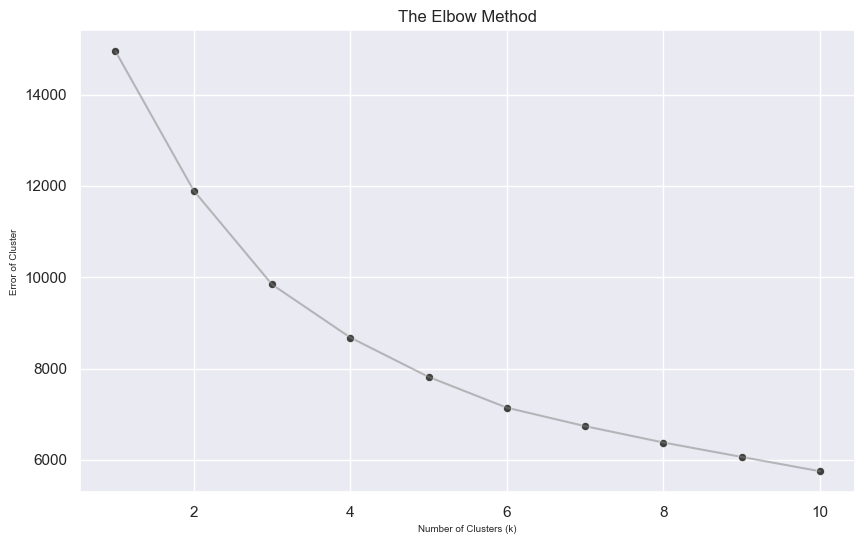

In [51]:
# Select features for clustering
features = ['product_size_large_count', 'product_size_small_count', 'product_line_road_count', 'product_line_touring_count', 'product_line_standard_count']
X_cluster = df[features]

# Standardize the features
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# Initialize a list to store the error for each number of clusters
error = []

# Use the Elbow method to find the optimal number of clusters
for k in range(1, 11):
    model = KMeans(n_clusters=k, random_state=12)
    model.fit(X_cluster_scaled)
    error.append(model.inertia_)

# Plot the Elbow curve with blurred line connecting the data points
plt.figure(figsize=(10, 6))
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Error of Cluster')

# Plot blurred line connecting the data points
sns.lineplot(x=list(range(1, 11)), y=error, marker='o', linestyle='-', color='grey', alpha=0.5)

# Plot data points
sns.scatterplot(x=list(range(1, 11)), y=error, marker='o', color='black')

plt.xticks(rotation=0)  # Rotate x-axis labels for better visibility
plt.show()

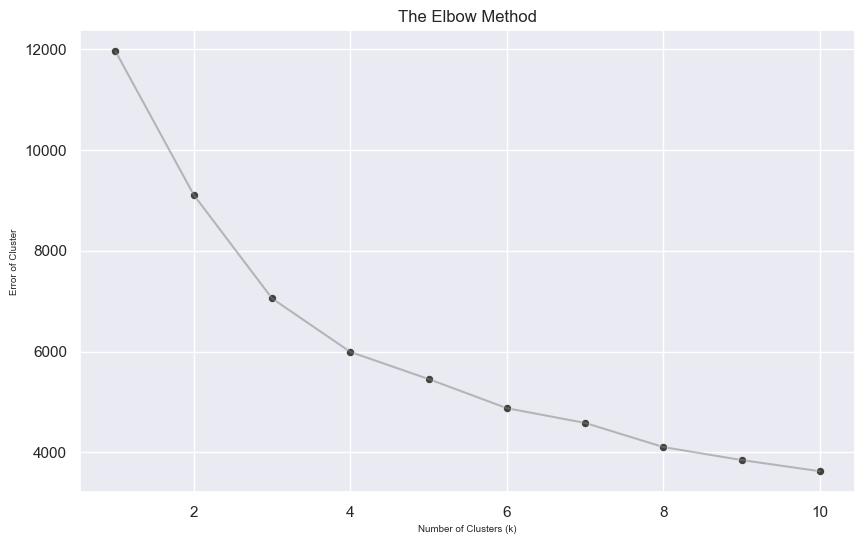

In [52]:
# Select features for clustering
features = ['product_size_large_count', 'product_size_small_count', 'product_line_road_count', 'product_line_touring_count']
X_cluster = df[features]

# Standardize the features
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# Initialize a list to store the error for each number of clusters
error = []

# Use the Elbow method to find the optimal number of clusters
for k in range(1, 11):
    model = KMeans(n_clusters=k, random_state=12)
    model.fit(X_cluster_scaled)
    error.append(model.inertia_)

# Plot the Elbow curve with blurred line connecting the data points
plt.figure(figsize=(10, 6))
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Error of Cluster')

# Plot blurred line connecting the data points
sns.lineplot(x=list(range(1, 11)), y=error, marker='o', linestyle='-', color='grey', alpha=0.5)

# Plot data points
sns.scatterplot(x=list(range(1, 11)), y=error, marker='o', color='black')

plt.xticks(rotation=0)  # Rotate x-axis labels for better visibility
plt.show()

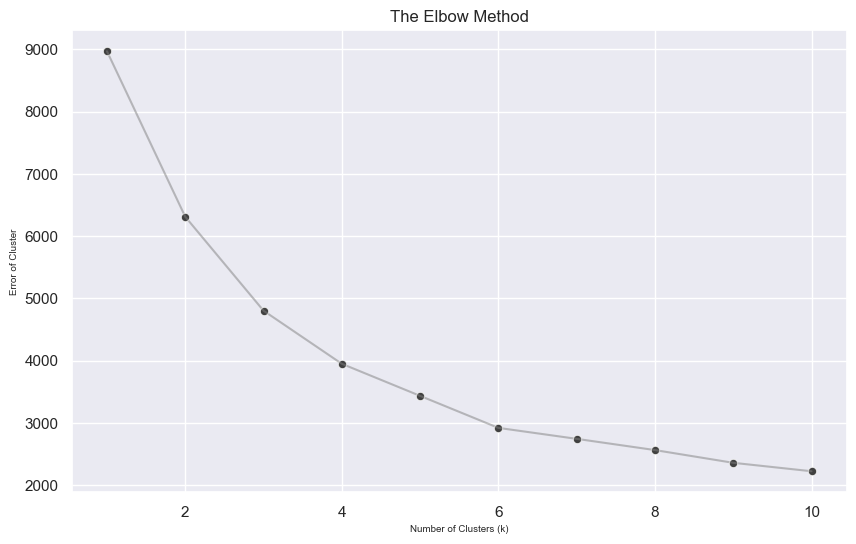

In [53]:
# Select features for clustering
features = ['product_size_large_count', 'product_size_small_count', 'product_line_road_count']
X_cluster = df[features]

# Standardize the features
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# Initialize a list to store the error for each number of clusters
error = []

# Use the Elbow method to find the optimal number of clusters
for k in range(1, 11):
    model = KMeans(n_clusters=k, random_state=12)
    model.fit(X_cluster_scaled)
    error.append(model.inertia_)

# Plot the Elbow curve with blurred line connecting the data points
plt.figure(figsize=(10, 6))
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Error of Cluster')

# Plot blurred line connecting the data points
sns.lineplot(x=list(range(1, 11)), y=error, marker='o', linestyle='-', color='grey', alpha=0.5)

# Plot data points
sns.scatterplot(x=list(range(1, 11)), y=error, marker='o', color='black')

plt.xticks(rotation=0)  # Rotate x-axis labels for better visibility
plt.show()

In [54]:
# Select features for clustering
features = ['product_size_large_count', 'product_size_small_count', 'product_line_road_count', 'product_line_touring_count']
X_cluster = df[features]

# Standardize the features and fit the KMeans model
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# Fit KMeans model with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=12)
kmeans.fit(X_cluster_scaled)

KMeans(n_clusters=3, random_state=12)

In [55]:
X_cluster = X_cluster.assign(cluster = model.labels_)
X_cluster.head()

product_size_large_count  product_size_small_count  \
0                         0                         2   
1                         0                         0   
3                         2                         2   
6                         3                         0   
7                         1                         0   

   product_line_road_count  product_line_touring_count  cluster  
0                        3                           0        1  
1                        0                           0        2  
3                        3                           0        6  
6                        1                           1        7  
7                        1                           0        9

In [56]:
# Calculate marker size and color based on features
marker_size = X_cluster['product_size_large_count'] + 5
marker_color = X_cluster['cluster']

# Create 3D scatter plot
fig = go.Scatter3d(
    x=X_cluster['product_size_small_count'] + 1,
    y=X_cluster['product_line_road_count'] + 1,
    z=X_cluster['product_line_touring_count'] + 1,
    marker=dict(
        size=marker_size,
        color=marker_color,
        opacity=0.9,
        reversescale=True
    ),
    line=dict(width=0.02),
    mode='markers'
)

# Create layout and update scene labels
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='product_size_small_count'),
        yaxis=dict(title='product_line_road_count'),
        zaxis=dict(title='product_line_touring_count')
    )
)

# Create figure and update layout
figure = go.Figure(fig, layout)

# Show the figure
figure.show()


In [57]:
 layout = go.Layout(scene=dict(xaxis=dict(title='product_size_small_count'),
                               yaxis=dict(title='product_line_road_count'),
                               zaxis=dict(title='product_line_touring_count')),)

 plotly.offline.plot({'data':[fig],
                      'layout': layout},
                     auto_open=True,
                     filename=('Clustering Plot.html'))

'Clustering Plot.html'

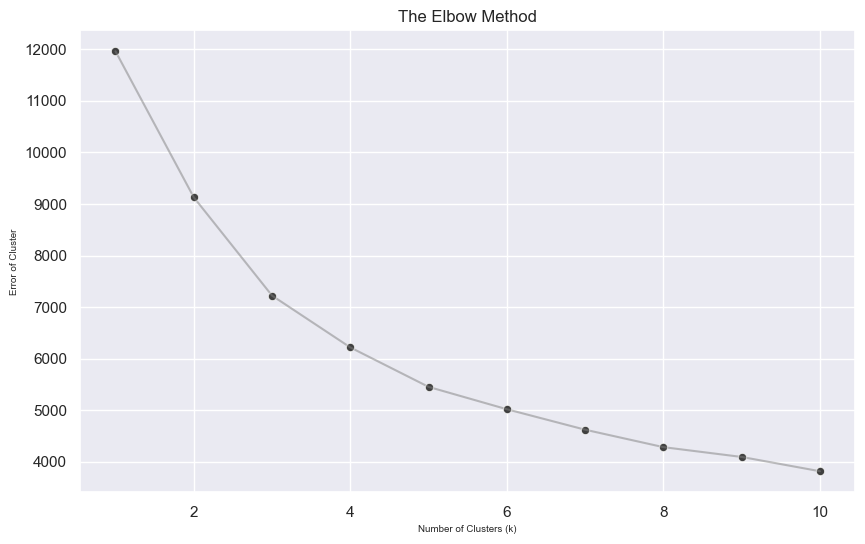

In [58]:
# Select features for clustering
features = ['product_size_large_count', 'product_size_small_count', 'product_line_road_count', 'average_profit_per_transaction']
X_cluster = df[features]

# Standardize the features
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# Initialize a list to store the error for each number of clusters
error = []

# Use the Elbow method to find the optimal number of clusters
for k in range(1, 11):
    model = KMeans(n_clusters=k, random_state=12)
    model.fit(X_cluster_scaled)
    error.append(model.inertia_)

# Plot the Elbow curve with blurred line connecting the data points
plt.figure(figsize=(10, 6))
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Error of Cluster')

# Plot blurred line connecting the data points
sns.lineplot(x=list(range(1, 11)), y=error, marker='o', linestyle='-', color='grey', alpha=0.5)

# Plot data points
sns.scatterplot(x=list(range(1, 11)), y=error, marker='o', color='black')

plt.xticks(rotation=0)  # Rotate x-axis labels for better visibility
plt.show()

In [59]:
model = KMeans(n_clusters = 3, random_state=12)
model.fit(X_cluster_scaled)

KMeans(n_clusters=3, random_state=12)

In [60]:
X_cluster.head()

product_size_large_count  product_size_small_count  \
0                         0                         2   
1                         0                         0   
3                         2                         2   
6                         3                         0   
7                         1                         0   

   product_line_road_count  average_profit_per_transaction  
0                        3                      274.371818  
1                        0                      742.086667  
3                        3                      399.156667  
6                        1                      596.043333  
7                        1                      392.185000

In [61]:
X_cluster = X_cluster.assign(cluster = model.labels_)

scaler2 = MinMaxScaler(feature_range=(1, 20))
scaler2.fit(X_cluster['average_profit_per_transaction'].values.reshape(-1, 1))
X_cluster['average_profit_per_transaction'] = scaler2.transform(X_cluster['average_profit_per_transaction'].values.reshape(-1, 1))

In [62]:
marker_size = X_cluster['average_profit_per_transaction']
marker_color = X_cluster['cluster']

fig = go.Scatter3d(x=X_cluster['product_size_small_count'] + 1,
                 y=X_cluster['product_line_road_count'] + 1,
                 z=X_cluster['product_size_large_count'] + 1,
                 marker=dict(size=marker_size,
                             color=marker_color,
                             opacity=0.9,
                             reversescale=True),
                            #  colorscale='Blues'),
                   line=dict(width=0.02),
                   mode='markers')

figure = go.Figure(fig)


figure.update_layout(scene=dict(xaxis=dict(title='product_size_small_count'),
                                yaxis=dict(title='product_line_road_count'),
                                zaxis=dict(title='product_line_large_count')),
                     width=800,
                     height=800)

figure.show()

In [63]:
 plotly.offline.plot({'data':[fig],
                      'layout': layout},
                     auto_open=True,
                     filename=('Clustering Plot2.html'))

'Clustering Plot2.html'

Start preparing to model data to get target customers.

Prepare data for training.

In [64]:
df_new.columns

Index(['first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure', 'address', 'postcode', 'state', 'country',
       'property_valuation', 'Rank', 'Value', 'Age', 'Age Group'],
      dtype='object')

In [65]:
df2 = df_copy
df2.columns

Index(['customer_id', 'transaction_count', 'days_since_first_purchase',
       'days_since_last_purchase', 'profit_sum', 'online_order_count',
       'product_line_mountain_count', 'product_line_road_count',
       'product_line_standard_count', 'product_line_touring_count',
       'product_class_high_count', 'product_class_low_count',
       'product_class_medium_count', 'product_size_large_count',
       'product_size_medium_count', 'product_size_small_count', 'gender',
       'past_3_years_bike_related_purchases', 'job_title',
       'job_industry_category', 'wealth_segment', 'owns_car', 'tenure', 'Age',
       'state', 'property_valuation', 'average_profit_per_transaction'],
      dtype='object')

In [66]:
df2 = df2[['gender', 'past_3_years_bike_related_purchases', 'Age', 'wealth_segment', 'owns_car', 'tenure', 'state', 'property_valuation', 'job_industry_category', 'average_profit_per_transaction']]
df2.columns

Index(['gender', 'past_3_years_bike_related_purchases', 'Age',
       'wealth_segment', 'owns_car', 'tenure', 'state', 'property_valuation',
       'job_industry_category', 'average_profit_per_transaction'],
      dtype='object')

In [67]:
df2 = df2.fillna({'job_industry_category':'No Info', 'tenure':0})

df2 = pd.get_dummies(data=df2, columns=['gender', 'job_industry_category', 'wealth_segment', 'state'])

In [68]:
X2_unscaled = df2.drop(columns = ['average_profit_per_transaction'])
y2 = df2['average_profit_per_transaction']

scaler = StandardScaler()
scaler.fit(X2_unscaled)
X2 = scaler.transform(X2_unscaled)

rf_model_file = 'kpmg_rf_model_file2.pkl'

cv_hyperparameter_rf(X2, y2)

MEAN CROSS-VALIDATION SCORE:  187.91925692092454
BEST HYPERPARAMETERS:  {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 7}
Parameter tuning with randomized search finished. Starting the model training with best performing parameters...
MEAN ABSOLUTE ERROR OF TRAINED BEST MODEL:  181.73514694574996


RandomForestRegressor(max_depth=7, max_features='log2', min_samples_leaf=2,
                      min_samples_split=10, n_estimators=300)

In [69]:
y.mean()

550.6817762779118

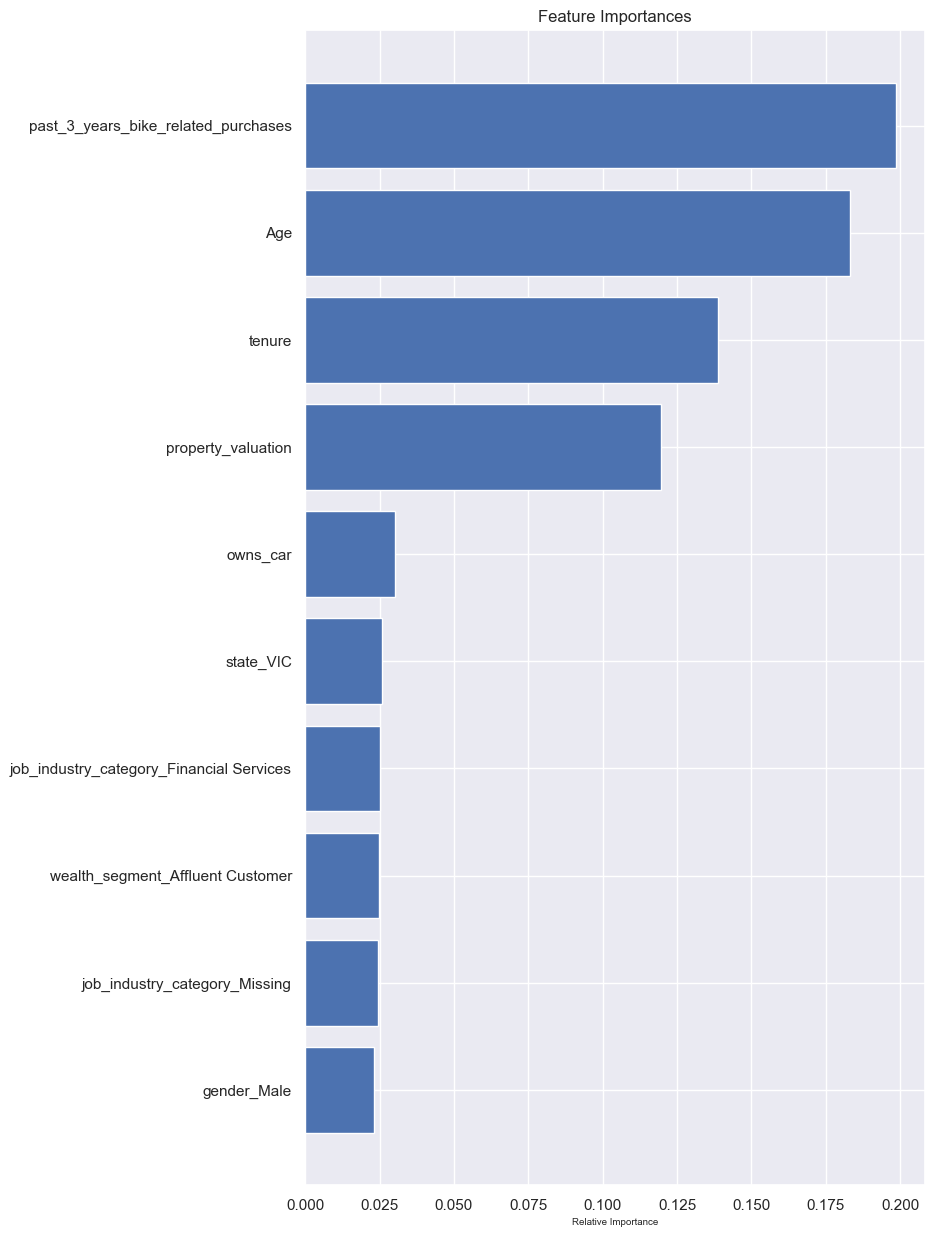

In [70]:
rf_model_file = 'kpmg_rf_model_file2.pkl'
rf_model = pickle.load(open(rf_model_file, 'rb'))

features = [i.split("__")[0] for i in X2_unscaled.columns]
importances = rf_model.feature_importances_
indices = np.argsort(importances)[-10:]

fig, ax = plt.subplots(figsize=(8, 15))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Process the new customers data for prediction.

In [71]:
df_new.columns

Index(['first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure', 'address', 'postcode', 'state', 'country',
       'property_valuation', 'Rank', 'Value', 'Age', 'Age Group'],
      dtype='object')

In [72]:
df_new = df_new[['gender', 'past_3_years_bike_related_purchases', 'DOB', 'job_industry_category', 'wealth_segment', 'owns_car', 'tenure', 'state', 'property_valuation']]
df_new.columns

Index(['gender', 'past_3_years_bike_related_purchases', 'DOB',
       'job_industry_category', 'wealth_segment', 'owns_car', 'tenure',
       'state', 'property_valuation'],
      dtype='object')

In [73]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 9 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   gender                               983 non-null    object
 1   past_3_years_bike_related_purchases  983 non-null    int64 
 2   DOB                                  983 non-null    object
 3   job_industry_category                983 non-null    object
 4   wealth_segment                       983 non-null    object
 5   owns_car                             983 non-null    object
 6   tenure                               983 non-null    int64 
 7   state                                983 non-null    object
 8   property_valuation                   983 non-null    int64 
dtypes: int64(3), object(6)
memory usage: 69.2+ KB


In [74]:
# Assuming 'DOB' is the name of the column containing date of birth
df_new['DOB'] = pd.to_datetime(df_new['DOB'], errors='coerce')

# Calculate Age
ref_date = pd.to_datetime('now')
df_new['Age'] = (ref_date - df_new['DOB']).dt.days / 365

# Fill missing values in 'Age' column with the mean
df_new['Age'] = df_new['Age'].fillna(df_new['Age'].mean())

# Convert 'Age' to integer
df_new['Age'] = df_new['Age'].astype(int)

# Display the first 3 rows
df_new.head(3)

gender  past_3_years_bike_related_purchases        DOB  \
0    Male                                   86 1957-07-12   
1    Male                                   69 1970-03-22   
2  Female                                   10 1974-08-28   

  job_industry_category     wealth_segment owns_car  tenure state  \
0         Manufacturing      Mass Customer      Yes      14   QLD   
1              Property      Mass Customer       No      16   NSW   
2    Financial Services  Affluent Customer       No      10   VIC   

   property_valuation  Age  
0                   6   66  
1                  11   53  
2                   5   49

In [75]:
df_new['owns_car'] = df_new['owns_car'].replace({'Yes':1, 'No':0})
df_new.head(3)

gender  past_3_years_bike_related_purchases        DOB  \
0    Male                                   86 1957-07-12   
1    Male                                   69 1970-03-22   
2  Female                                   10 1974-08-28   

  job_industry_category     wealth_segment  owns_car  tenure state  \
0         Manufacturing      Mass Customer         1      14   QLD   
1              Property      Mass Customer         0      16   NSW   
2    Financial Services  Affluent Customer         0      10   VIC   

   property_valuation  Age  
0                   6   66  
1                  11   53  
2                   5   49

In [76]:
df_new['state'] = df_new['state'].replace({'New South Wales':'NSW', 'Victoria':'VIC'})
df_new['state'].unique()

array(['QLD', 'NSW', 'VIC'], dtype=object)

In [77]:
df_new = df_new.drop(columns='DOB')
df_new.head(3)

gender  past_3_years_bike_related_purchases job_industry_category  \
0    Male                                   86         Manufacturing   
1    Male                                   69              Property   
2  Female                                   10    Financial Services   

      wealth_segment  owns_car  tenure state  property_valuation  Age  
0      Mass Customer         1      14   QLD                   6   66  
1      Mass Customer         0      16   NSW                  11   53  
2  Affluent Customer         0      10   VIC                   5   49

In [78]:
df_new = df_new.fillna({'job_industry_category':'No Info'})

In [79]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 9 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   gender                               983 non-null    object
 1   past_3_years_bike_related_purchases  983 non-null    int64 
 2   job_industry_category                983 non-null    object
 3   wealth_segment                       983 non-null    object
 4   owns_car                             983 non-null    int64 
 5   tenure                               983 non-null    int64 
 6   state                                983 non-null    object
 7   property_valuation                   983 non-null    int64 
 8   Age                                  983 non-null    int32 
dtypes: int32(1), int64(4), object(4)
memory usage: 65.4+ KB


In [80]:
X3_unscaled = pd.get_dummies(data=df_new, columns=['gender', 'job_industry_category', 'wealth_segment', 'state'])

Fit the new customers data to the model to get prediction.

In [81]:
scaler = StandardScaler()
scaler.fit(X3_unscaled)
X3 = scaler.transform(X3_unscaled)

rf_model_file = 'kpmg_rf_model_file2.pkl'
rf_model = pickle.load(open(rf_model_file, 'rb'))

y3_pred = rf_model.predict(X3)

In [82]:
y3_pred.dtype

dtype('float64')

In [83]:
df_new_pred = df_new

In [84]:
df_new_pred['predicted_average_profit_per_transaction'] = y3_pred

In [85]:
df_new_pred.columns

Index(['gender', 'past_3_years_bike_related_purchases',
       'job_industry_category', 'wealth_segment', 'owns_car', 'tenure',
       'state', 'property_valuation', 'Age',
       'predicted_average_profit_per_transaction'],
      dtype='object')

In [86]:
df_new_pred = df_new_pred.sort_values(by='predicted_average_profit_per_transaction', ascending=False)

### Create Clusters using the most recent model

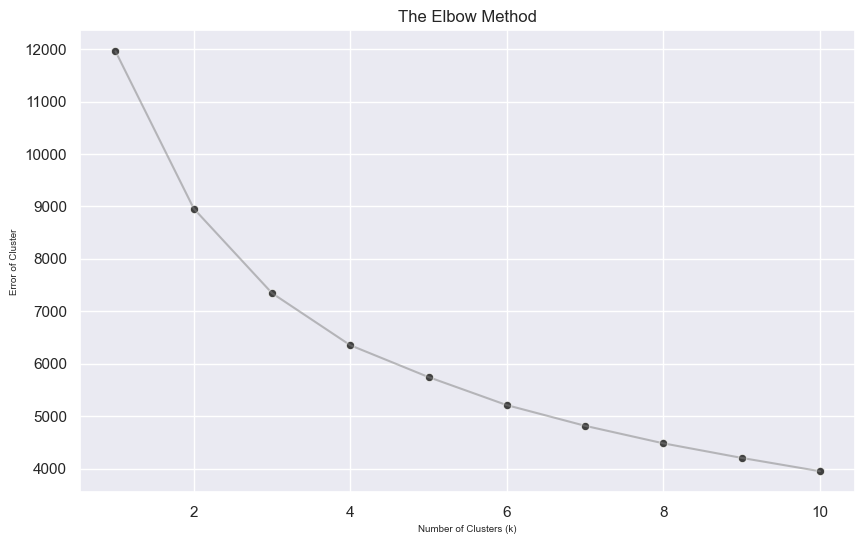

In [87]:
# Select features for clustering
features = ['past_3_years_bike_related_purchases', 'Age', 'tenure', 'average_profit_per_transaction']
X_cluster = df2[features]

# Standardize the features
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# Initialize a list to store the error for each number of clusters
error = []

# Use the Elbow method to find the optimal number of clusters
for k in range(1, 11):
    model = KMeans(n_clusters=k, random_state=12)
    model.fit(X_cluster_scaled)
    error.append(model.inertia_)

# Plot the Elbow curve with blurred line connecting the data points
plt.figure(figsize=(10, 6))
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Error of Cluster')

# Plot blurred line connecting the data points
sns.lineplot(x=list(range(1, 11)), y=error, marker='o', linestyle='-', color='grey', alpha=0.5)

# Plot data points
sns.scatterplot(x=list(range(1, 11)), y=error, marker='o', color='black')

plt.xticks(rotation=0)
plt.show()

In [88]:
model = KMeans(n_clusters = 3, random_state=12)
model.fit(X_cluster_scaled)

KMeans(n_clusters=3, random_state=12)

In [89]:
# Select features for clustering
X_cluster = df2[['past_3_years_bike_related_purchases', 'Age', 'tenure', 'average_profit_per_transaction']]

# Assign cluster labels
X_cluster['cluster'] = model.labels_

# Using MinMaxScaler to scale 'average_profit_per_transaction'
scaler = MinMaxScaler(feature_range=(1, 20))
X_cluster['average_profit_per_transaction'] = scaler.fit_transform(X_cluster['average_profit_per_transaction'].values.reshape(-1, 1))

In [90]:
marker_size = X_cluster['average_profit_per_transaction']
marker_color = X_cluster['cluster']

fig = go.Scatter3d(x=X_cluster['past_3_years_bike_related_purchases'],
                 y=X_cluster['Age'],
                 z=X_cluster['tenure'],
                 marker=dict(size=marker_size,
                             opacity=0.9,
                             color=marker_color,
                             reversescale=True),
                            #  colorscale='Blues'),
                   line=dict(width=0.02),
                   mode='markers')

figure = go.Figure(fig)


figure.update_layout(scene=dict(xaxis=dict(title='past_3_years_bike_related_purchases'),
                                yaxis=dict(title='age'),
                                zaxis=dict(title='tenure')),
                     width=800,
                     height=800)

figure.show()

In [91]:
 plotly.offline.plot({'data':[fig],
                      'layout': layout},
                     auto_open=True,
                     filename=('Clustering Plot3.html'))

'Clustering Plot3.html'